In [133]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import numpy as np



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [134]:
def convert_for_test_data(start_date_str,end_date_str,solar):
    
    #end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column
    
    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])
    
    
    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    #solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

In [135]:
#tab is a function given 1 array,and i dataframe contain power_output, combine to dataframe
def tab(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [136]:
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [137]:
nov_test=pd.read_csv("NOV_test_data.csv")
nov_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2020-11-01 10:00:00,77.6,10.1,327.0,1.0,NaN,27.6,31.90,7.95,8.26,7.69,5.13,23.01
1,1,2020-11-01 10:15:00,25.7,3.1,315.0,NaN,NaN,27.6,32.02,8.51,8.11,7.52,5.01,23.73
2,2,2020-11-01 10:30:00,25.7,5.3,315.0,NaN,NaN,25.6,32.14,9.07,7.95,7.35,4.89,24.45
3,3,2020-11-01 10:45:00,25.7,7.9,315.0,1.0,NaN,25.6,36.68,9.38,9.12,8.15,5.59,28.05
4,4,2020-11-01 11:00:00,25.7,10.5,315.0,NaN,NaN,28.6,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
2876,2876,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
2877,2877,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
2878,2878,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [138]:
weather=pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather.drop(columns=['datetime (UTC)'], inplace=True)
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 10:00:00,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
2010-01-01 11:00:00,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2010-01-01 12:00:00,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
2010-01-01 13:00:00,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
2010-01-01 14:00:00,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...
2021-06-01 06:00:00,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
2021-06-01 07:00:00,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
2021-06-01 08:00:00,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00


In [139]:
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
datetime (UTC),,,,,,,,
2010-01-01 10:00:00,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-06-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
# newweather = newweather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 10:00:00,18.3,16.4,2.6,101046.4,0.9,287.0,408.4,1.0
2010-01-01 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00,18.7,16.3,2.9,101038.0,0.9,360.8,411.0,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.8,3.9,5.6,102077.1,0.7,80.5,296.2,1.0
2021-06-01 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
final_test=pd.read_csv("finaltest.csv")
final_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2016-07-04 07:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-07-04 07:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-07-04 08:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-07-04 08:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-07-04 08:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154661,154661,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
154662,154662,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
154663,154663,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
154664,154664,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [142]:
def column_value(data, solar_number):
    a=data[['Date',solar_number]]
    a=a.dropna()
    a['series_name']=solar_number
    a.rename(columns={'Date':'start_timestamp',solar_number:'series_value'}, inplace=True)
    columns = a.columns.tolist()
    columns[0], columns[1],columns[2] = columns[2], columns[0],columns[1]
    a= a[columns]
    return a




In [143]:
def train_data(start,data):
    data['start_timestamp'] = pd.to_datetime(data['start_timestamp'])

    start_date = start
    end_date = '2020-11-01 10:00:00'
    df=data
    solar_0_train = df[(df['start_timestamp'] >= start_date) & (df['start_timestamp'] <= end_date)]
    # print(subset_df)
    return solar_0_train

In [144]:
def train_split_mod(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data
# Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.

    # Create a table of the various scores.
    result=pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return result



In [145]:
def predic_value(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.
    return testing_predictions

In [146]:
# for log base 2, for predicted value. can be miss.
def tab1(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['logarithm_base2_1']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [147]:
# def tab2(predict_data,actual_data):
#     d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
#     df = pd.DataFrame(data=d)
#     df = df.reset_index(0)
#     return df

In [148]:
#two array form dataframe
def tab3(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

# solar train data

In [149]:
solar_0_train=column_value(final_test,'Solar0')
solar_0_train=train_data('2020-04-26 00:00:00',solar_0_train)
solar_1_train=column_value(final_test,'Solar1')
solar_1_train=train_data('2018-12-31 23:00:00',solar_1_train)
solar_2_train=column_value(final_test,'Solar2')
solar_2_train=train_data('2019-06-06 00:00:00',solar_2_train)
solar_3_train=column_value(final_test,'Solar3')
solar_3_train=train_data('2019-06-06 00:00:00',solar_3_train)
solar_4_train=column_value(final_test,'Solar4')
solar_4_train=train_data('2019-06-06 00:00:00',solar_4_train)
solar_5_train=column_value(final_test,'Solar5')
solar_5_train=train_data('2019-01-15 23:00:00',solar_5_train)

In [150]:
solar_0_train = convert_for_test_data("2020-04-26 00:00:00",'2020-11-01 10:00:00',solar_0_train)
solar_1_train = convert_for_test_data("2018-12-31 23:00:00","2020-11-01 10:00:00",solar_1_train)
solar_2_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_2_train)
solar_3_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_3_train)
solar_4_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_4_train)
solar_5_train = convert_for_test_data("2019-01-15 23:00:00","2020-11-01 10:00:00",solar_5_train)

# solar test data

In [151]:
solar_0_test_1=column_value(nov_test,'Solar0')
solar_1_test_1=column_value(nov_test,'Solar1')
solar_2_test_1=column_value(nov_test,'Solar2')
solar_3_test_1=column_value(nov_test,'Solar3')
solar_4_test_1=column_value(nov_test,'Solar4')
solar_5_test_1=column_value(nov_test,'Solar5')

In [152]:
solar_0_test_1 = convert_for_test_data("2020-11-01 10:00:00",'2020-12-01 09:45:00',solar_0_test_1)
solar_1_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_1_test_1)
solar_2_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_2_test_1)
solar_3_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_3_test_1)
solar_4_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_4_test_1)
solar_5_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_5_test_1)

# solar 0

In [184]:
solar_0_train.dropna(inplace=True)
solar_0_test_1.dropna(inplace=True)
X_train=solar_0_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_0_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_0_train['power_output']
Y_test = solar_0_test_1['power_output']

In [185]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.889931,3.347107,2.544474
test,0.884880,5.552656,4.104271


In [186]:
solar_0=predic_value(X_train,X_test,Y_train,Y_test)
df0=tab(solar_0,solar_0_test_1)
df0

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,26.732015,31.90
1,2020-11-01 11:00:00,30.517271,41.22
2,2020-11-01 12:00:00,33.055308,47.59
3,2020-11-01 13:00:00,33.354160,45.80
4,2020-11-01 14:00:00,32.026187,40.36
...,...,...,...
715,2020-12-01 05:00:00,-2.993375,0.81
716,2020-12-01 06:00:00,12.012592,10.01
717,2020-12-01 07:00:00,9.722186,6.20
718,2020-12-01 08:00:00,8.158676,4.56


In [187]:
df0.set_index('timestamp', inplace=True)

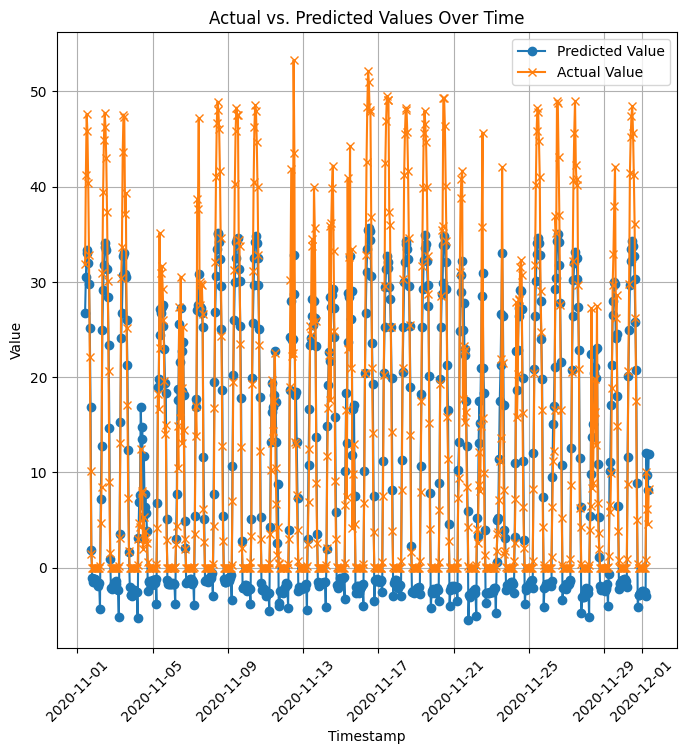

In [188]:
plt.figure(figsize=(8, 8))
plt.plot(df0.index, df0['Predicted'], label='Predicted Value', marker='o')
plt.plot(df0.index, df0['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [189]:
original_accuracy_0=r2_score(Y_test, solar_0)

# log predict small value

In [200]:
# solar_0_train['log']=np.log(solar_0_train['power_output']+10**(-3))
# solar_0_test_1['log']=np.log(solar_0_test_1['power_output']+10**(-3))
#train_split_mod
Y_train_log = np.log(Y_train+10**(-3))
Y_test_log = np.log(Y_test+10**(-3))

In [201]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
train_split_mod(X_train,X_test,Y_train_log,Y_test_log)

,R^2,RMSE,MAE
train,1.0,7.490932e-14,6.240084e-14
test,1.0,9.461706e-14,7.854705e-14


In [202]:
#get the predicted value
solar_0_log=predic_value(X_train,X_test,Y_train_log,Y_test_log)

In [203]:
#exp of the predicted value
solar_0_log_1=np.exp(solar_0_log)

In [204]:
solar_0_log_1

array([3.1901e+01, 4.1221e+01, 4.7591e+01, 4.5801e+01, 4.0361e+01,
       3.2821e+01, 2.2091e+01, 1.0181e+01, 1.4110e+00, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02, 1.7100e-01,
       4.7110e+00, 8.4910e+00, 3.0981e+01, 3.9411e+01, 4.4881e+01,
       4.7751e+01, 4.6291e+01, 4.3021e+01, 3.7331e+01, 3.0061e+01,
       2.0641e+01, 8.9810e+00, 1.5010e+00, 1.1000e-02, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 1.1000e-02, 1.3100e-01, 3.1010e+00,
       1.3101e+01, 3.0371e+01, 3.3641e+01, 4.3661e+01, 4.7561e+01,
       4.7301e+01, 3.7161e+01, 3.9331e+01, 2.5201e+01, 1.7051e+01,
       7.3310e+00, 1.7910e+00, 1.1000e-02, 1.1000e-02, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02, 1.1000e-02,
       1.1000e-02, 1.1000e-02, 2.3100e-01, 3.0010e+00, 4.7310e+00,
       4.2510e+00, 1.2491e+01, 8.0210e+00, 7.8310e+00, 1.9710e

In [205]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
df0_log=tab(solar_0_log_1,solar_0_test_1)
df0_log

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,31.901,31.90
1,2020-11-01 11:00:00,41.221,41.22
2,2020-11-01 12:00:00,47.591,47.59
3,2020-11-01 13:00:00,45.801,45.80
4,2020-11-01 14:00:00,40.361,40.36
...,...,...,...
715,2020-12-01 05:00:00,0.811,0.81
716,2020-12-01 06:00:00,10.011,10.01
717,2020-12-01 07:00:00,6.201,6.20
718,2020-12-01 08:00:00,4.561,4.56


In [206]:
small_log_accuracy_0=r2_score(solar_0_test_1['power_output'],solar_0_log_1)

# log plus one

In [221]:
# #use this function to create a new column call "log_1" in the solatr dataframe.
# solar_0_test_1['log_1']=np.log(solar_0_test_1['power_output']+1)
# solar_0_train['log_1']=np.log(solar_0_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_0_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_0_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_0_train['log_1']
# Y_test_log_plus_1 = solar_0_test_1['log_1']
Y_train_log = np.log(Y_train+1)
Y_test_log = np.log(Y_test+1)

In [222]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


,R^2,RMSE,MAE
train,0.694591,0.697230,0.473816
test,0.716194,0.831799,0.588063


In [223]:
#the predicted_value function will provide the predicted value for the model
solar_0_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [224]:
#this one shows thw minimum of the predictd value
min(solar_0_log_plus_1)


-1.079996173224281

In [225]:
#set all the predicted value which less than 0 to 0
# solar_0_log_plus_1[solar_0_log_plus_1<0]=0
#test whether it works or not
min(solar_0_log_plus_1)


-1.079996173224281

In [226]:
#do the exponetian of the predicted value and minus 1 to turn the data back
solar_0_log_plus_1=np.exp(solar_0_log_plus_1)-1


In [227]:
#tab3 is a function the provide two array, and combined them as a dataFrame.
df0_log_plus_tab=tab(solar_0_log_plus_1,solar_0_test_1)
df0_log_plus_tab


,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,24.145287,31.90
1,2020-11-01 11:00:00,65.822090,41.22
2,2020-11-01 12:00:00,188.149639,47.59
3,2020-11-01 13:00:00,247.299515,45.80
4,2020-11-01 14:00:00,187.203757,40.36
...,...,...,...
715,2020-12-01 05:00:00,-0.205270,0.81
716,2020-12-01 06:00:00,0.037050,10.01
717,2020-12-01 07:00:00,1.585728,6.20
718,2020-12-01 08:00:00,2.468984,4.56


In [228]:
#get the r^2 square value of the y_test data and the predicted data.
plus_1_log_accuracy_0=r2_score(solar_0_test_1['power_output'],solar_0_log_plus_1)

# absolute

In [229]:
df0_2=df0
df0_2[df0_2<0]=0

In [230]:
absolute_accuracy_0=r2_score(df0_2['Actual'],df0_2['Predicted'])

# result

In [231]:
original_accuracy_0

0.884879511670075

In [232]:
small_log_accuracy_0

0.9999999962661998

In [233]:
plus_1_log_accuracy_0

-9.612561603792557

In [234]:
absolute_accuracy_0

0.8950637215417102